In [ ]:
# Synnax Datathon 3: XGBoost + SHAP Project

## Step 1: Install & Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [ ]:
## Step 2: Load Data
import zipfile
with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("synnax_data")

X_train = pd.read_csv('synnax_data/X_train.csv')
macro_train = pd.read_csv('synnax_data/macro_train.csv')
targets_train = pd.read_csv('synnax_data/targets_train.csv')
X_test = pd.read_csv('synnax_data/X_forward_looking.csv')
macro_test = pd.read_csv('synnax_data/macro_forward_looking.csv')
sample_submission = pd.read_csv('synnax_data/sample_submission.csv')

In [ ]:


# STEP 3: Merge training data
final_train = X_train.merge(macro_train, on='companyId').merge(targets_train, on='companyId')
target_cols = [col for col in targets_train.columns if col != 'companyId']
X = final_train.drop(columns=target_cols + ['companyId'])

# STEP 4: Encode features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat_encoded = pd.DataFrame(ohe.fit_transform(X[categorical_cols]), index=X.index)
X_prepared = pd.concat([X[numerical_cols].fillna(0), X_cat_encoded], axis=1)

# STEP 5: Train models
model_dict = {}
for target in target_cols:
    y = final_train[target].fillna(0)
    X_train_, X_val, y_train_, y_val = train_test_split(X_prepared, y, test_size=0.2, random_state=42)
    model = xgb.XGBRegressor(random_state=42, n_estimators=100)
    model.fit(X_train_, y_train_)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f'{target} - Validation RMSE: {rmse:.4f}')
    model_dict[target] = model

# STEP 6: Prepare test data
final_test = X_test.merge(macro_test, on='companyId')
X_test_cat_encoded = pd.DataFrame(ohe.transform(final_test[categorical_cols]), index=final_test.index)
X_test_prepared = pd.concat([final_test[numerical_cols].fillna(0), X_test_cat_encoded], axis=1)

# STEP 7: Make predictions
submission = pd.DataFrame({'companyId': X_test['companyId']})
for target in target_cols:
    submission[target] = model_dict[target].predict(X_test_prepared)

# STEP 8: Save submission
submission.to_csv('submission.csv', index=False)
print(" submission.csv saved!")


target_7 - Validation RMSE: 0.0174
target_43 - Validation RMSE: 0.0189
target_34 - Validation RMSE: 0.0179
target_42 - Validation RMSE: 0.0179
target_9 - Validation RMSE: 0.0187
target_27 - Validation RMSE: 0.0162
target_99 - Validation RMSE: 0.0175
target_105 - Validation RMSE: 0.0162
target_24 - Validation RMSE: 0.0178
target_83 - Validation RMSE: 0.0193
target_80 - Validation RMSE: 0.0218
target_52 - Validation RMSE: 0.0160
target_4 - Validation RMSE: 0.0160
target_69 - Validation RMSE: 0.0168
target_88 - Validation RMSE: 0.0171
target_85 - Validation RMSE: 0.0166
target_134 - Validation RMSE: 0.0189
 submission.csv saved!


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

training_rmse_results = {}

for target in target_cols:
    y = final_train[target].fillna(0)

    # Train/Val Split
    X_train_, X_val, y_train_, y_val = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

    model = model_dict[target]
    y_train_pred = model.predict(X_train_)

    train_rmse = np.sqrt(mean_squared_error(y_train_, y_train_pred))
    training_rmse_results[target] = train_rmse
    print(f"{target} - Training RMSE: {train_rmse:.4f}")


target_7 - Training RMSE: 0.0000
target_43 - Training RMSE: 0.0001
target_34 - Training RMSE: 0.0000
target_42 - Training RMSE: 0.0001
target_9 - Training RMSE: 0.0001
target_27 - Training RMSE: 0.0001
target_99 - Training RMSE: 0.0000
target_105 - Training RMSE: 0.0001
target_24 - Training RMSE: 0.0001
target_83 - Training RMSE: 0.0001
target_80 - Training RMSE: 0.0001
target_52 - Training RMSE: 0.0001
target_4 - Training RMSE: 0.0000
target_69 - Training RMSE: 0.0000
target_88 - Training RMSE: 0.0000
target_85 - Training RMSE: 0.0001
target_134 - Training RMSE: 0.0001


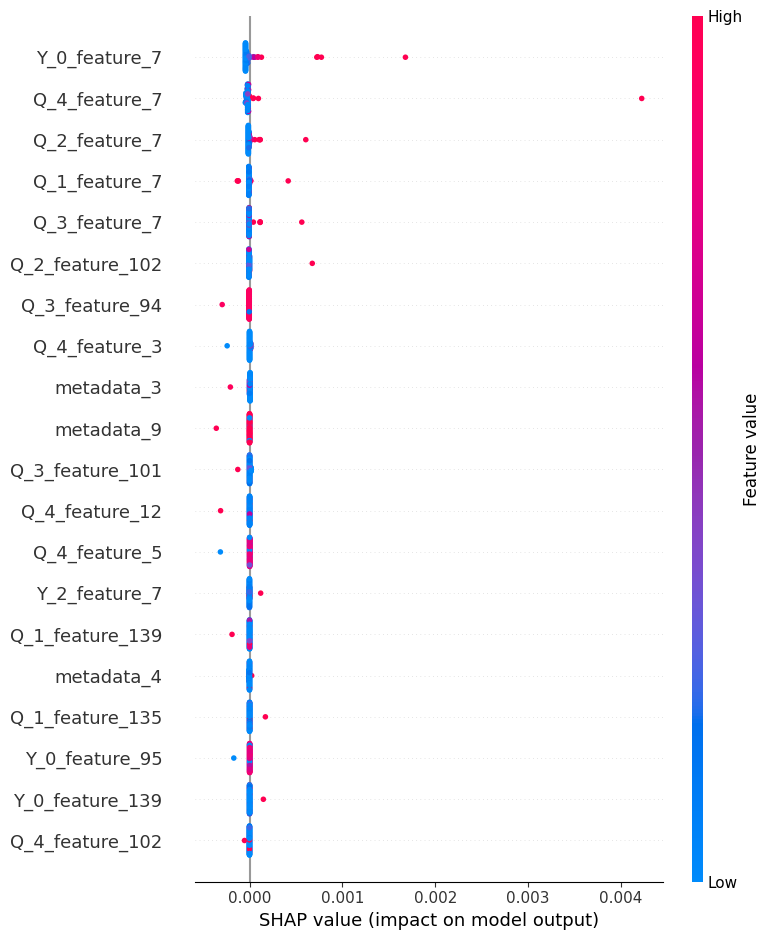

target_7 RMSE: 0.0174


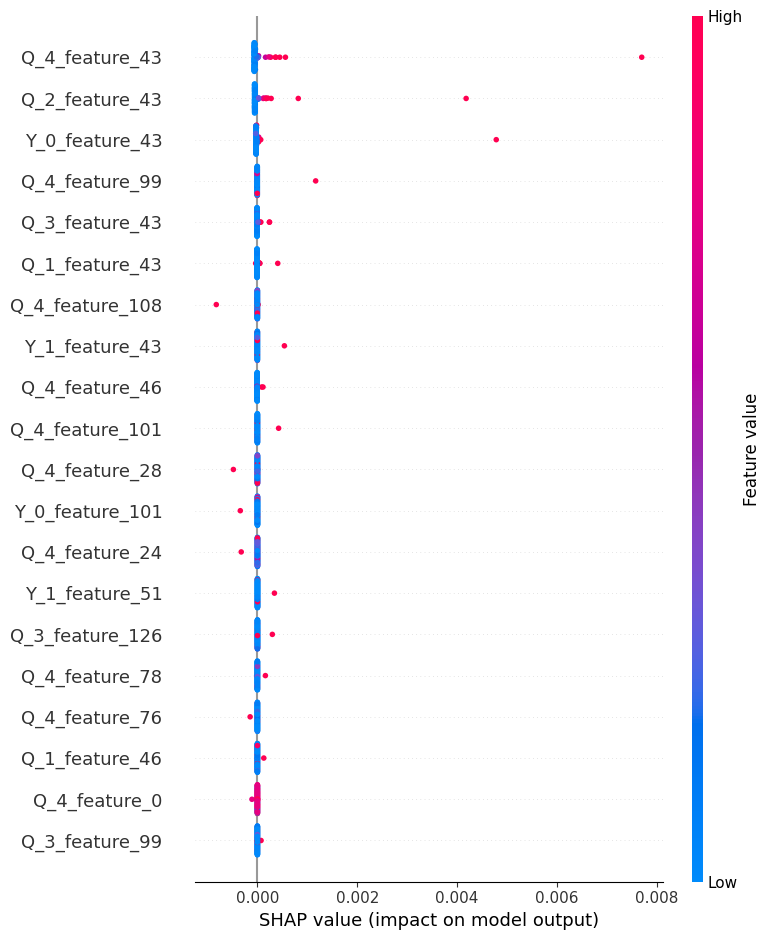

target_43 RMSE: 0.0189


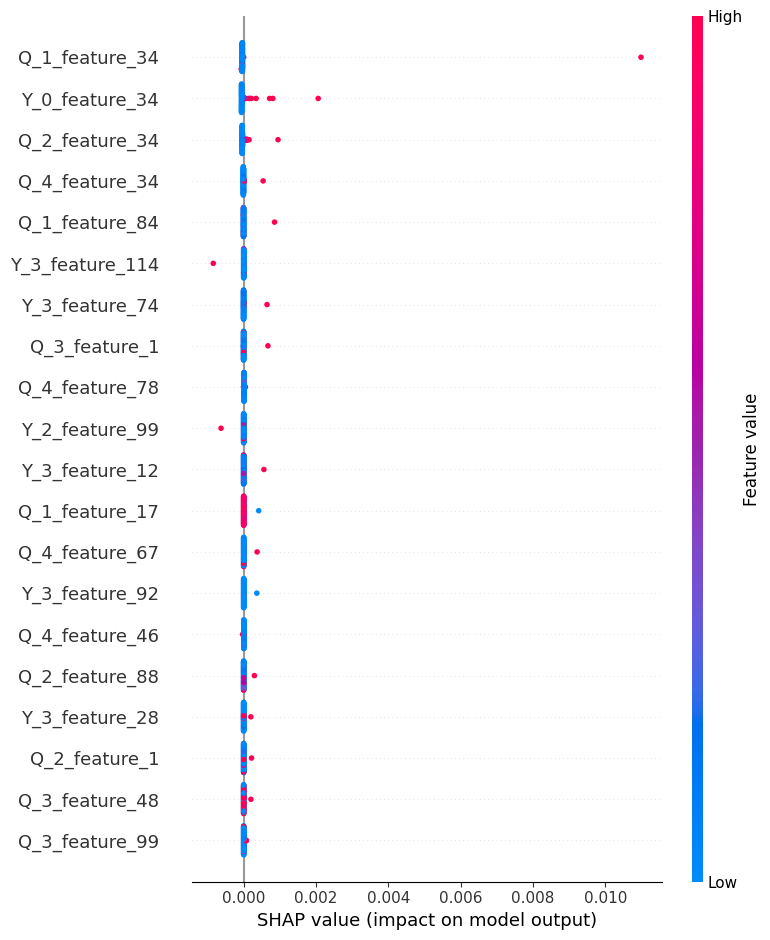

target_34 RMSE: 0.0179


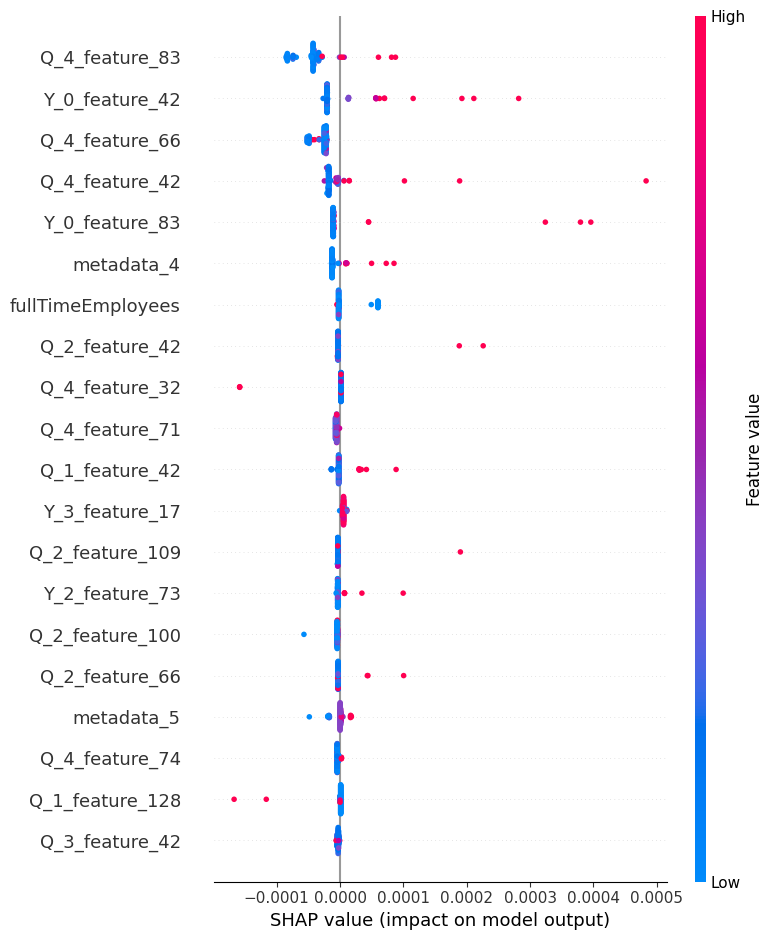

target_42 RMSE: 0.0179


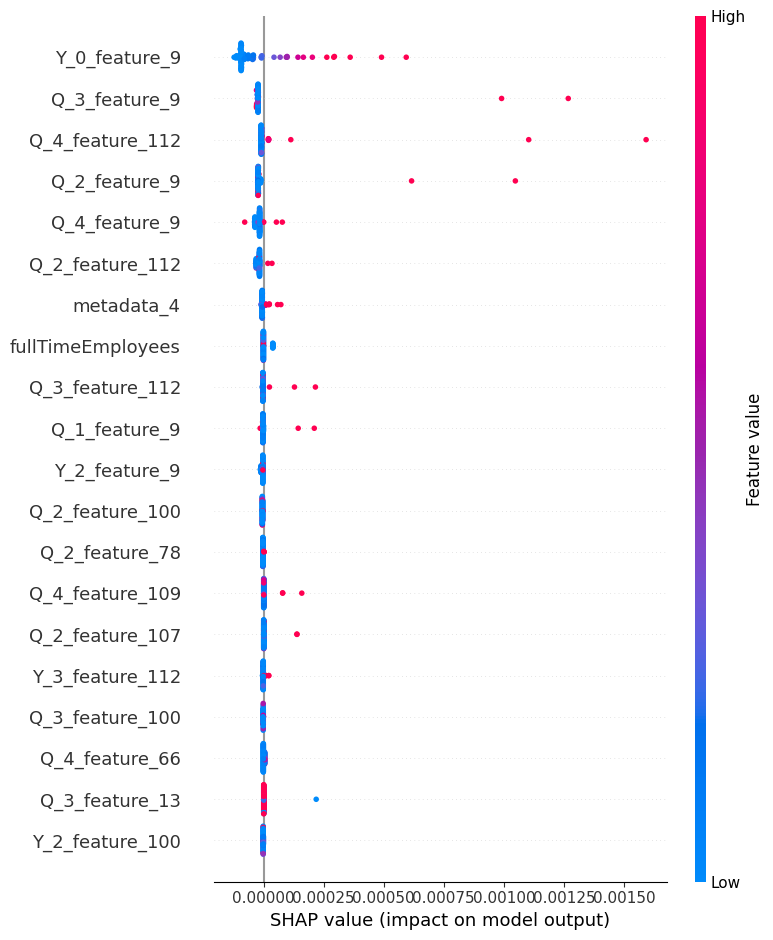

target_9 RMSE: 0.0187


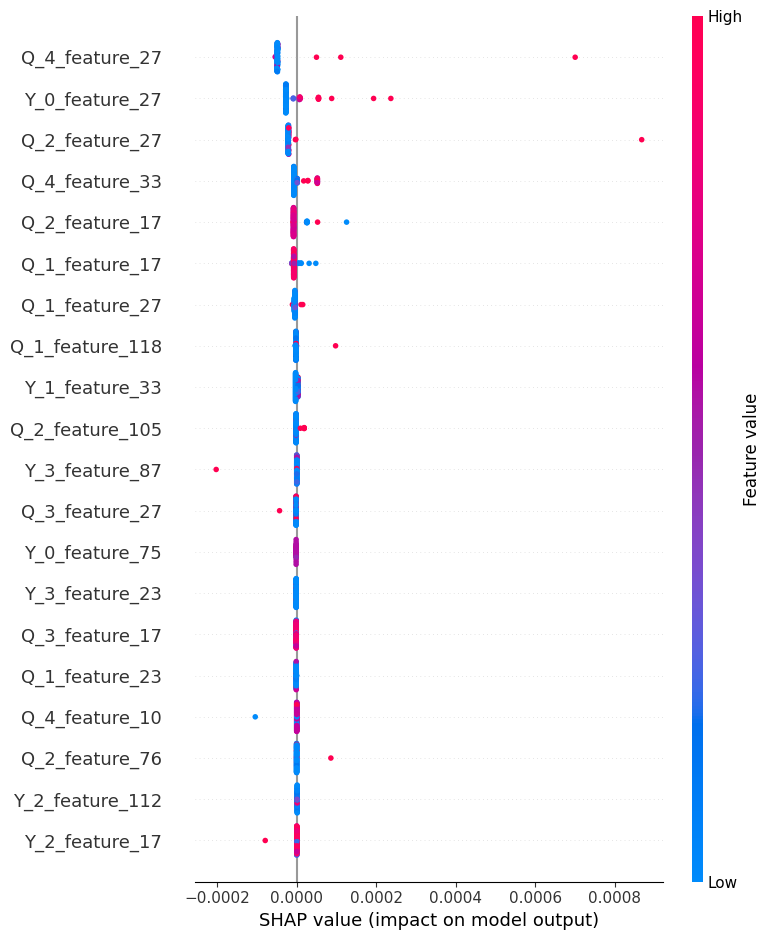

target_27 RMSE: 0.0162


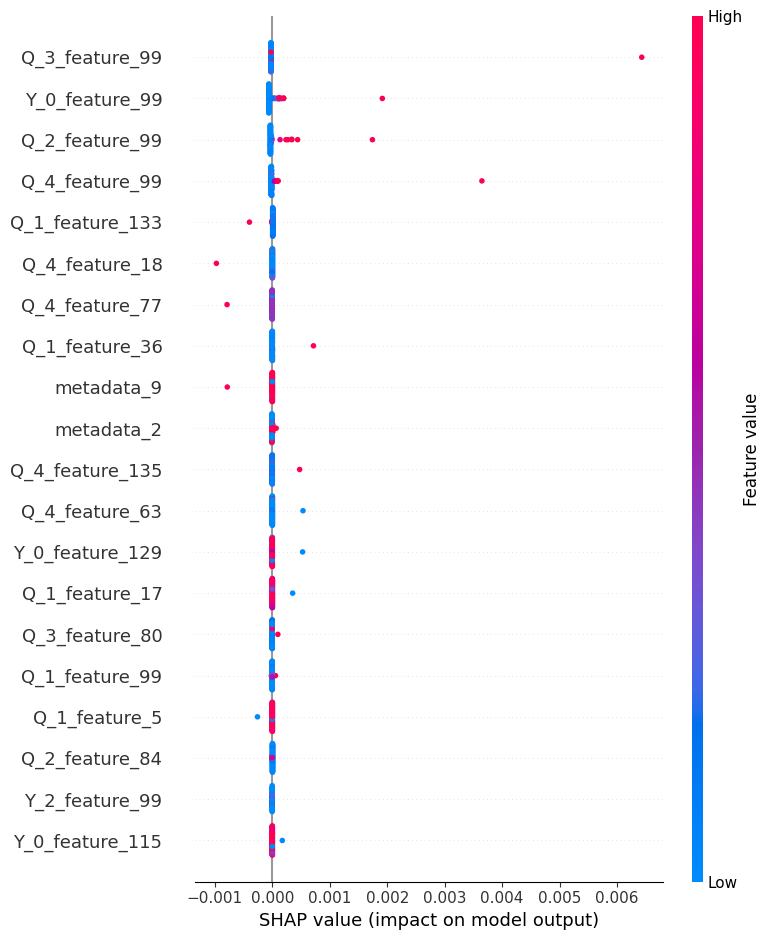

target_99 RMSE: 0.0175


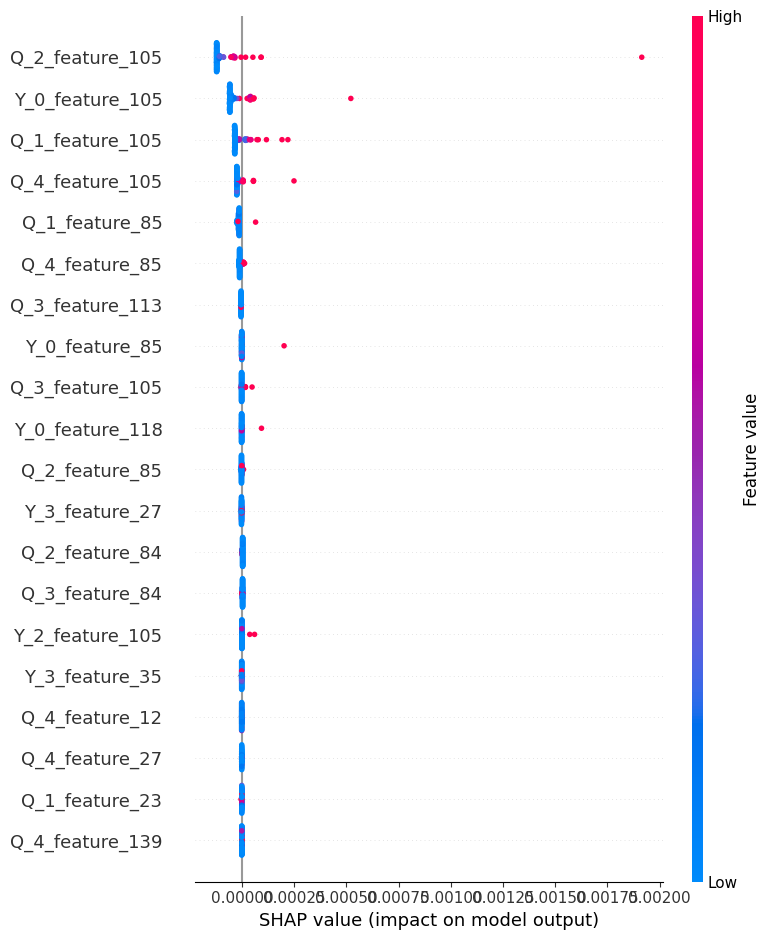

target_105 RMSE: 0.0162


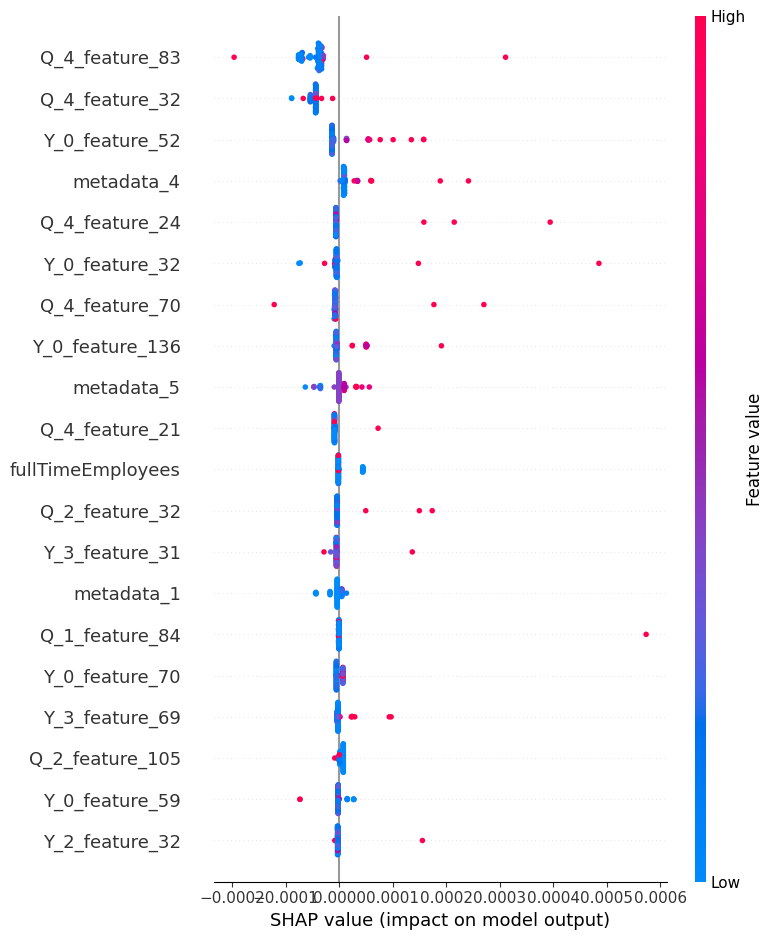

target_24 RMSE: 0.0178


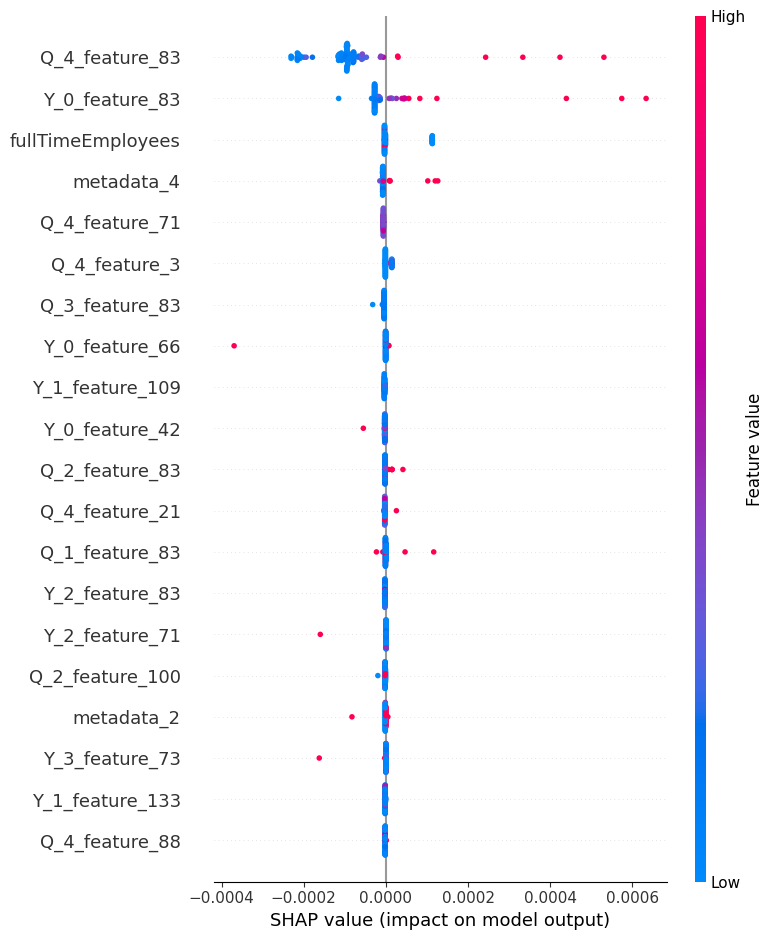

target_83 RMSE: 0.0193


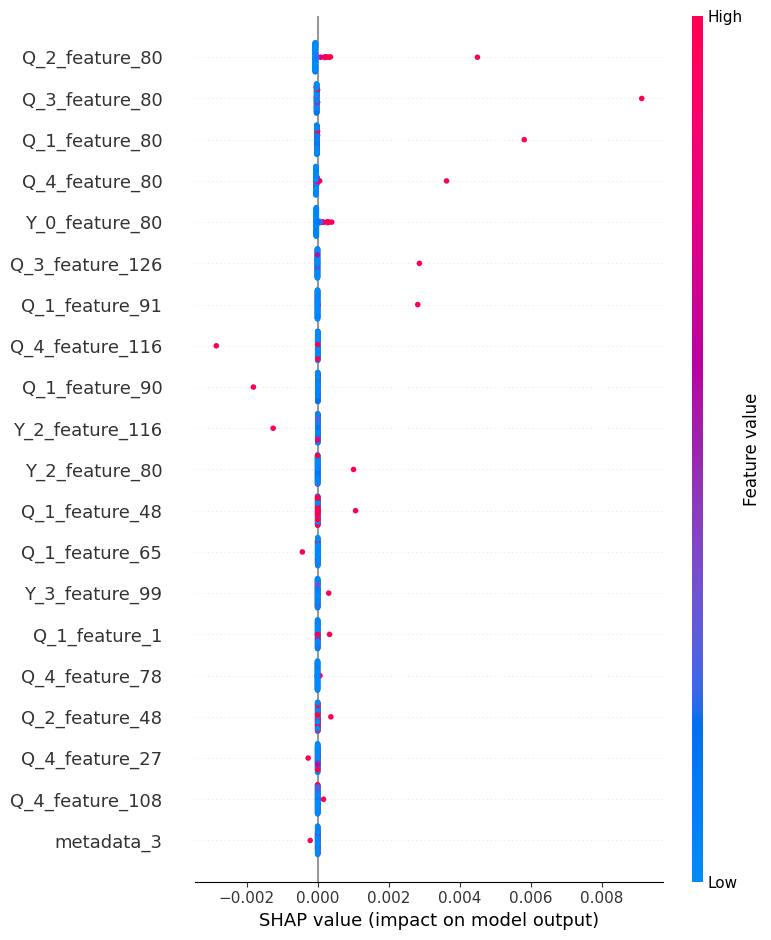

target_80 RMSE: 0.0218


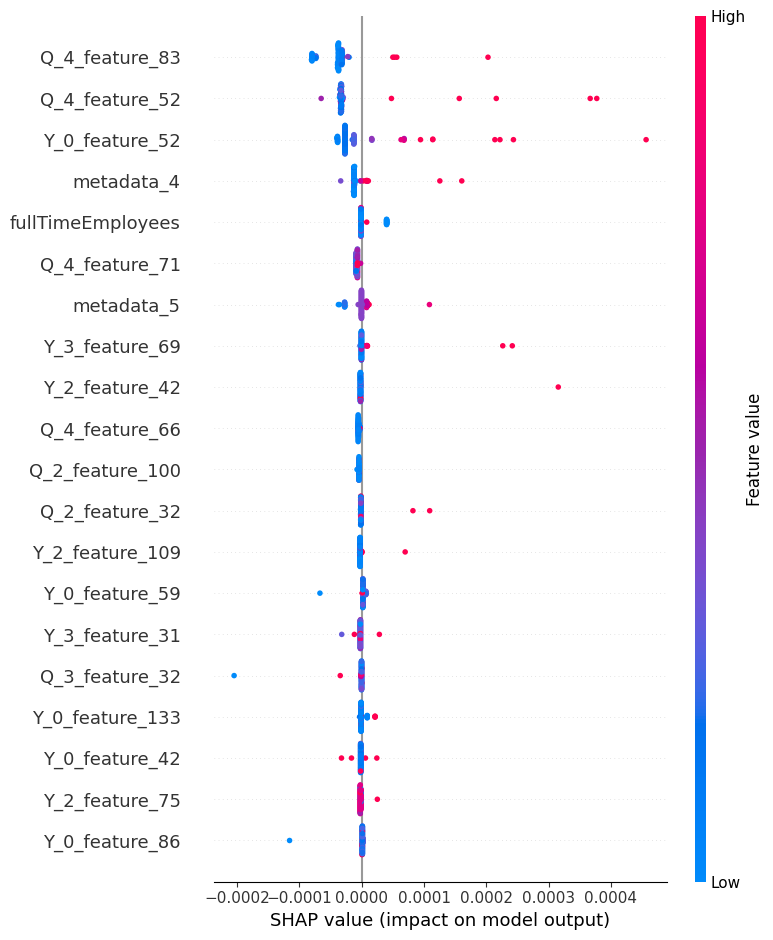

target_52 RMSE: 0.0160


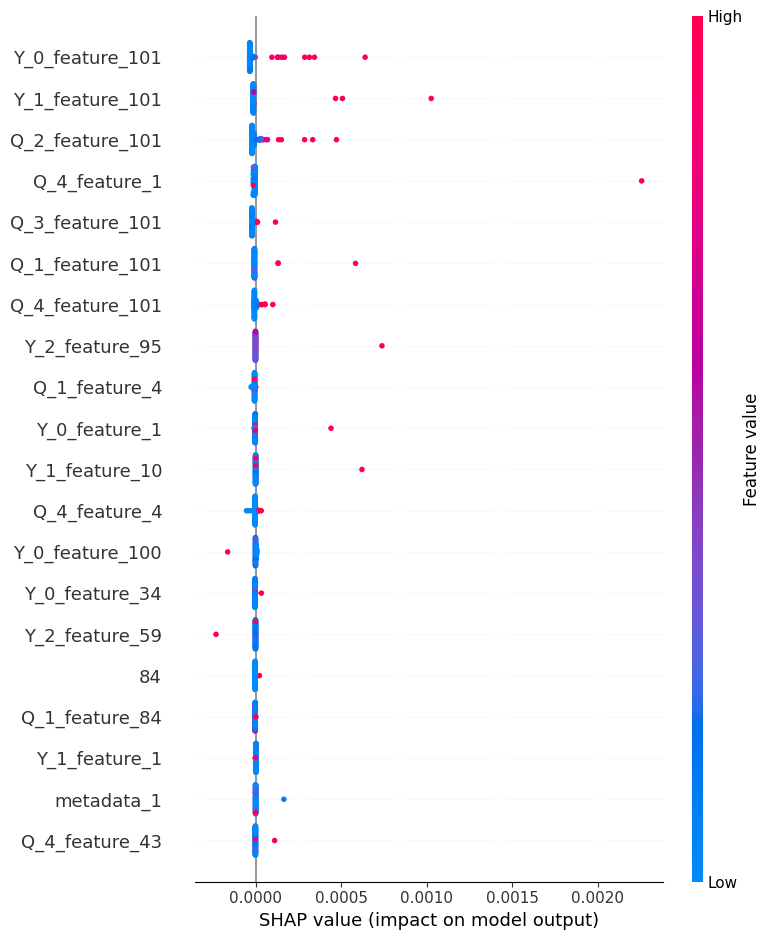

target_4 RMSE: 0.0160


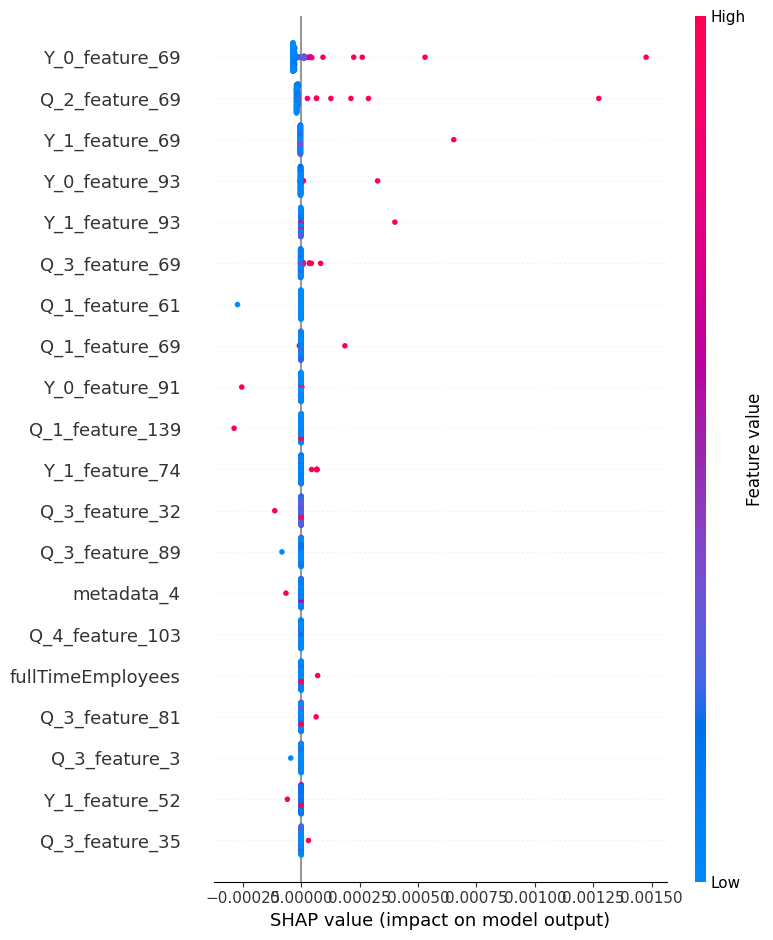

target_69 RMSE: 0.0168


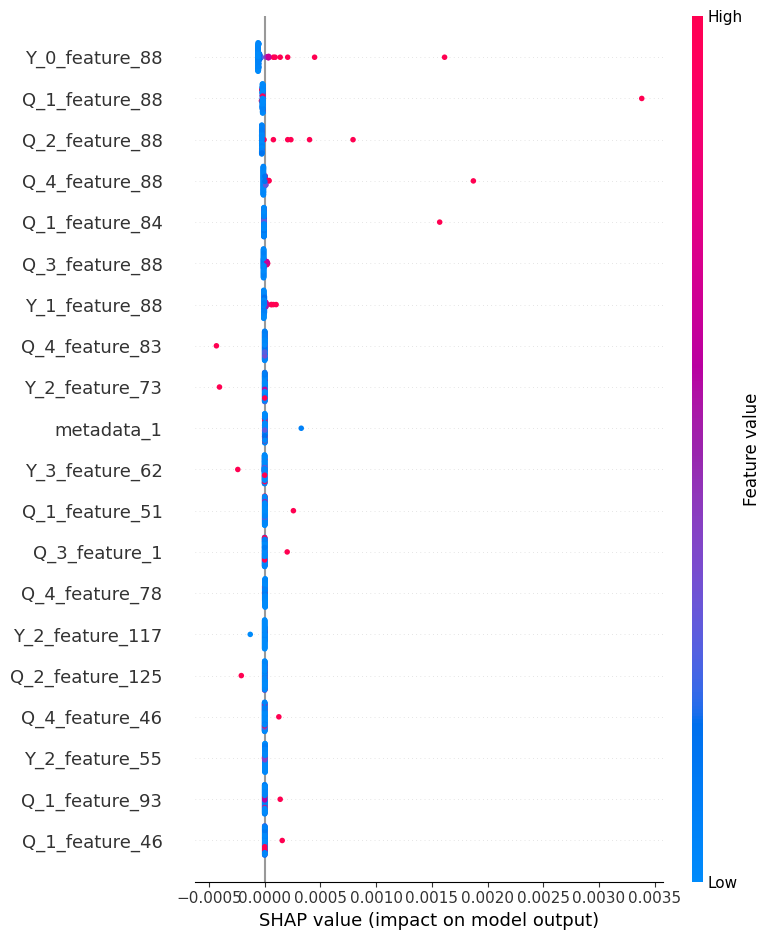

target_88 RMSE: 0.0171


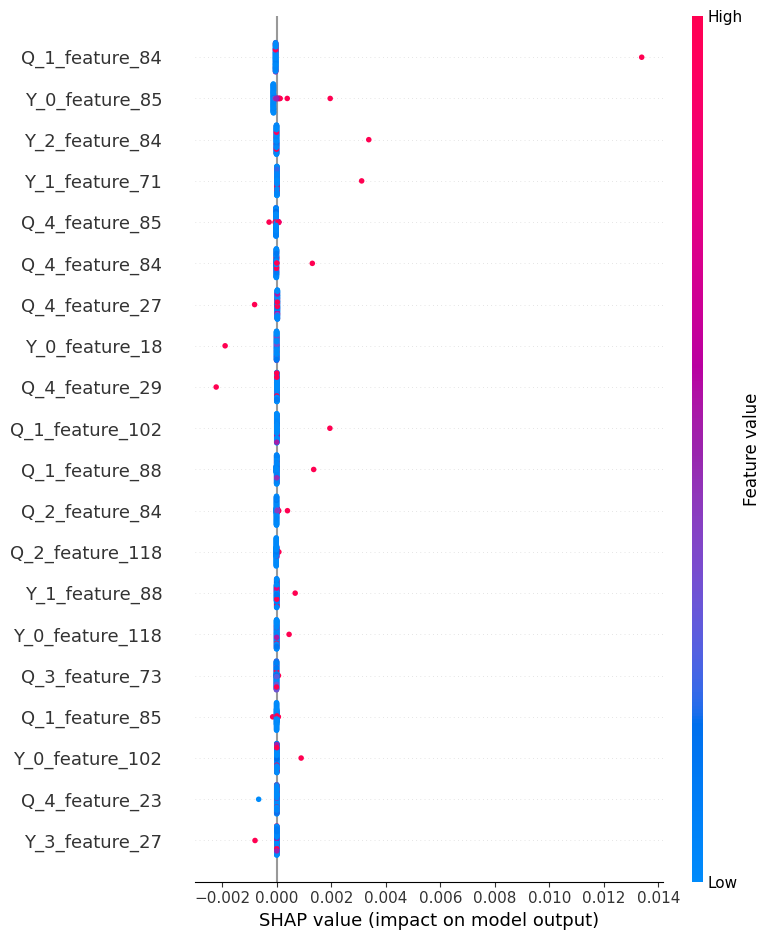

target_85 RMSE: 0.0166


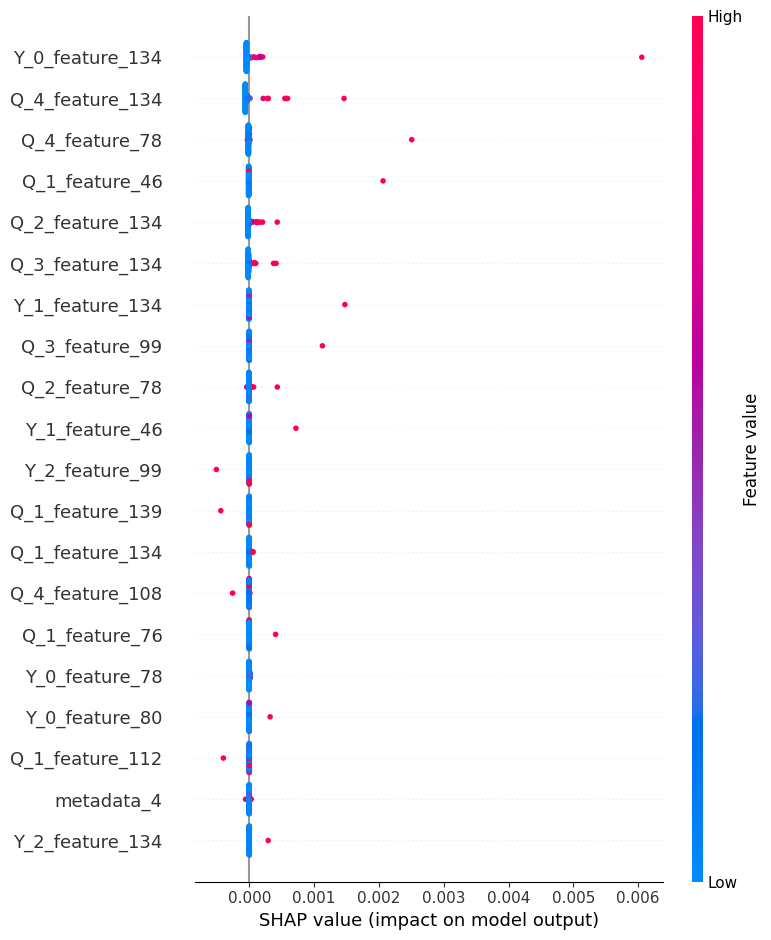

target_134 RMSE: 0.0189


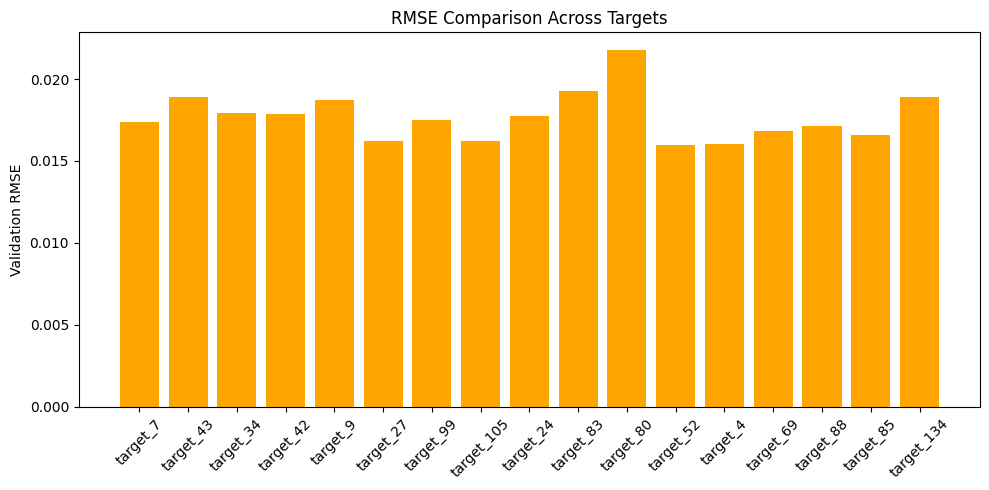

In [ ]:
import shap
import matplotlib.pyplot as plt

shap.initjs()
rmse_results = {}

for target in target_cols:
    model = model_dict[target]
    y = final_train[target].fillna(0)

    # Split again for SHAP (same as training)
    X_train_, X_val, y_train_, y_val = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

    # TreeExplainer is safest for XGBoost
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val[:100])  # For speed, first 100 rows only

    # SHAP Summary Plot
    plt.title(f"SHAP Summary for {target}")
    shap.summary_plot(shap_values, X_val[:100], show=True)

    # RMSE Calculation
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_results[target] = rmse
    print(f"{target} RMSE: {rmse:.4f}")

# Plot RMSE Comparison
plt.figure(figsize=(10, 5))
plt.bar(rmse_results.keys(), rmse_results.values(), color='orange')
plt.ylabel("Validation RMSE")
plt.title("RMSE Comparison Across Targets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
